# Chicago Crime — Exploratory Data Analysis (EDA)

**Data source:** City of Chicago Crimes (Socrata) → `raw.chicago_crimes` → `public_stg.stg_chicago_crimes` via dbt  
**Window:** configurable in the first code cell (`WINDOW_START`, `WINDOW_END`)  
**Purpose:** Understand crime volume, composition, temporal patterns, arrest rates, and location hotspots to inform downstream modeling and dashboarding.

**Table of Contents**
1. Crime Type Distribution
2. Monthly Trends (2025 Window)
3. Day-of-Week & Hour-of-Day Patterns
4. Arrest Rate Analysis
5. Location Hotspots (Location × Hour Heatmap)
6. Top Movers (Absolute & % Change)
7. Key Findings & Next Steps

In [1]:
from dotenv import load_dotenv
load_dotenv()  # loads .env into this process

import os, pandas as pd, sqlalchemy as sa, psycopg
from IPython.display import Markdown, display

# Build engine 
engine = sa.create_engine(
    f"postgresql+psycopg://{os.getenv('PGUSER')}:{os.getenv('PGPASSWORD')}@"
    f"{os.getenv('PGHOST')}:{os.getenv('PGPORT')}/{os.getenv('PGDATABASE')}"
)

In [2]:
# Global filters for this notebook
WINDOW_START = "2025-07-01"  # adjust if needed
WINDOW_END = None            # or e.g. "2025-09-30"

def date_clause(col="date"):
    """Builds WHERE clause for queries based on global date filters."""
    end = f" AND {col} < '{WINDOW_END}'" if WINDOW_END else ""
    return f"{col} >= '{WINDOW_START}'{end}"

print("Using window:", date_clause())

# Query helper
def q(sql):
    """Shortcut to run SQL queries with the global engine."""
    return pd.read_sql(sql, engine)

Using window: date >= '2025-07-01'


In [3]:
# Row counts + distinct IDs
q("""
SELECT
    COUNT(*) AS rows,
    COUNT(DISTINCT source_id) AS distinct_ids
FROM raw.chicago_crimes;
""")

,rows,distinct_ids
0,5801,5801


## 1. Crime Type Distribution

**What this shows:** The most frequent crime categories in the selected time window.  
**Why it matters:** Helps focus downstream analysis/models on major drivers of volume.

In [4]:
# Look at crime types inside JSON
q("""
SELECT payload ->> 'primary_type' AS crime_type, COUNT(*) AS n
FROM raw.chicago_crimes
GROUP BY 1
ORDER BY n DESC
LIMIT 25;
""")

,crime_type,n
0,THEFT,1209
1,BATTERY,1126
2,CRIMINAL DAMAGE,589
3,ASSAULT,522
4,MOTOR VEHICLE THEFT,414
5,OTHER OFFENSE,407
6,DECEPTIVE PRACTICE,366
7,BURGLARY,263
8,NARCOTICS,186
9,ROBBERY,157


In [5]:
q("""
SELECT primary_type, COUNT(*) AS n
FROM public_stg.stg_chicago_crimes
GROUP BY 1
ORDER BY n DESC
LIMIT 25;
""")

,primary_type,n
0,THEFT,1209
1,BATTERY,1126
2,CRIMINAL DAMAGE,589
3,ASSAULT,522
4,MOTOR VEHICLE THEFT,414
5,OTHER OFFENSE,407
6,DECEPTIVE PRACTICE,366
7,BURGLARY,263
8,NARCOTICS,186
9,ROBBERY,157


In [6]:
# Time coverage 
q("""
SELECT 
    MIN(date) AS first_record,
    MAX(date) AS last_record,
    COUNT(*) AS total_rows
FROM public_stg.stg_chicago_crimes;
""")

,first_record,last_record,total_rows
0,2001-08-26 11:45:00,2025-09-05,5801


In [7]:
# Monthly trends by crime type 
q("""
SELECT 
    DATE_TRUNC('month', date) AS month,
    primary_type,
    COUNT(*) AS n
FROM public_stg.stg_chicago_crimes
GROUP BY 1,2
ORDER BY month, n DESC;
""")


,month,primary_type,n
0,2001-08-01,CRIMINAL TRESPASS,1
1,2001-08-01,CRIMINAL SEXUAL ASSAULT,1
2,2001-08-01,CRIMINAL DAMAGE,1
3,2001-11-01,CRIMINAL SEXUAL ASSAULT,1
4,2004-03-01,DECEPTIVE PRACTICE,1
...,...,...,...
195,2025-09-01,HOMICIDE,2
196,2025-09-01,PROSTITUTION,2
197,2025-09-01,CONCEALED CARRY LICENSE VIOLATION,1
198,2025-09-01,OBSCENITY,1


In [8]:
# Arrest rates 
q("""
SELECT 
  primary_type,
  COUNT(*) AS total,
  SUM(CASE WHEN arrest THEN 1 ELSE 0 END) AS arrests,
  ROUND(100.0 * SUM(CASE WHEN arrest THEN 1 ELSE 0 END) / COUNT(*), 2) AS arrest_rate_pct
FROM public_stg.stg_chicago_crimes
GROUP BY primary_type
ORDER BY total DESC
LIMIT 15;
""")
  

,primary_type,total,arrests,arrest_rate_pct
0,THEFT,1209,109,9.02
1,BATTERY,1126,186,16.52
2,CRIMINAL DAMAGE,589,23,3.90
3,ASSAULT,522,64,12.26
4,MOTOR VEHICLE THEFT,414,7,1.69
5,OTHER OFFENSE,407,71,17.44
6,DECEPTIVE PRACTICE,366,15,4.10
7,BURGLARY,263,11,4.18
8,NARCOTICS,186,175,94.09
9,ROBBERY,157,14,8.92


In [9]:
# Location hot spots 
q("""
SELECT
    location_description,
    COUNT(*) AS n
FROM public_stg.stg_chicago_crimes
GROUP BY location_description
ORDER BY n DESC
LIMIT 15;
""")

,location_description,n
0,STREET,1504
1,APARTMENT,1087
2,RESIDENCE,715
3,SIDEWALK,355
4,PARKING LOT / GARAGE (NON RESIDENTIAL),219
5,SMALL RETAIL STORE,192
6,ALLEY,147
7,DEPARTMENT STORE,129
8,RESTAURANT,105
9,VEHICLE NON-COMMERCIAL,103


In [10]:
# Trend over time by major crime categories 
q("""
SELECT DATE_TRUNC('year', date) AS year,
  primary_type,
  COUNT(*) AS n
FROM public_stg.stg_chicago_crimes
WHERE primary_type IN ('THEFT', 'BATTERY', 'ASSAULT', 'BURGLARY', 'NARCOTICS')
GROUP BY 1,2
ORDER BY year, n DESC;
""")


,year,primary_type,n
0,2010-01-01,BATTERY,1
1,2017-01-01,BATTERY,1
2,2019-01-01,BATTERY,1
3,2021-01-01,BATTERY,1
4,2022-01-01,BATTERY,2
5,2022-01-01,ASSAULT,1
6,2023-01-01,THEFT,1
7,2024-01-01,BATTERY,6
8,2024-01-01,ASSAULT,2
9,2024-01-01,BURGLARY,2


## 2. Monthly Trends (2025 Window)

**What this shows:** Month-to-month total incidents and composition (stacked by type).  
**Why it matters:** Reveals seasonal shifts and recent surges/declines.

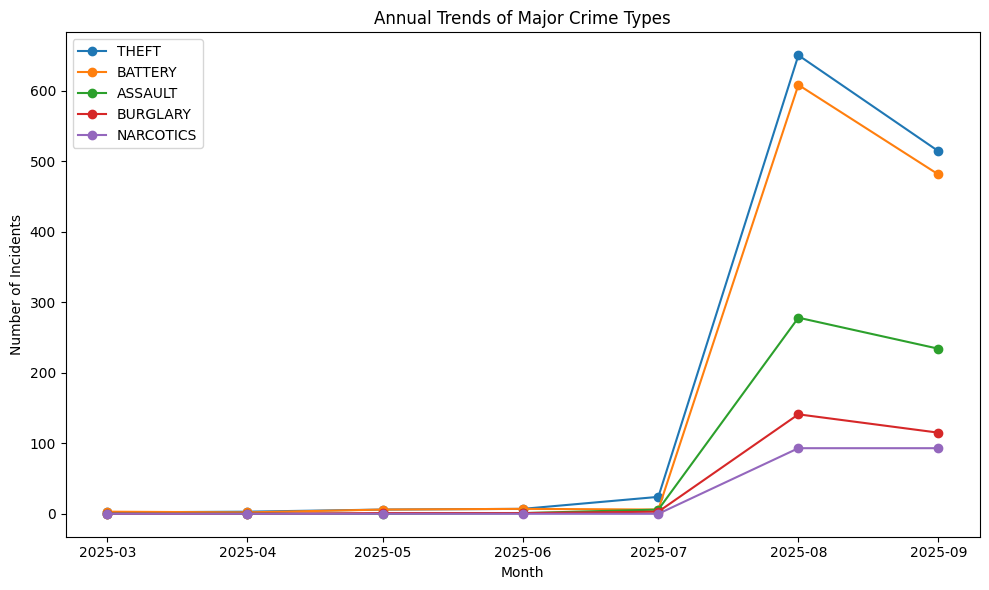

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

df = q("""
SELECT DATE_TRUNC('month', date) AS month,
       primary_type,
       COUNT(*) AS n
FROM public_stg.stg_chicago_crimes
WHERE date >= '2024-01-01'
    AND primary_type IN ('THEFT','BATTERY','ASSAULT','BURGLARY','NARCOTICS')
GROUP BY 1,2
ORDER BY month, n DESC;
""")

# Ensure datetime and tidy index
df['month'] = pd.to_datetime(df['month']).dt.to_period('M').dt.to_timestamp()

# Filter for recent incidents 
recent = df[df['month'] >= "2025-03-01"]

# Pivot so each column is a crime type, rows are months
pivot = (recent
         .pivot_table(index='month', columns='primary_type', values='n', aggfunc='sum')
         .sort_index()
         .fillna(0))

# Limit to top 5 columns by total count
top_cols = pivot.sum().sort_values(ascending=False).head(5).index
pivot = pivot[top_cols]

plt.figure(figsize=(10,6))
for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], marker='o', label=col)

plt.title("Annual Trends of Major Crime Types")
plt.xlabel("Month")
plt.ylabel("Number of Incidents")
plt.legend()
plt.tight_layout()
plt.show()

**Note:** Theft and Battery dominate overall incident volume in the current window.

## 3. Day-of-Week & Hour-of-Day Patterns

**What this shows:** When crimes concentrate within a week and a day; grouped to top crime types + OTHER.  
**Why it matters:** Timing patterns help with patrol scheduling, resource allocation, and alerting.

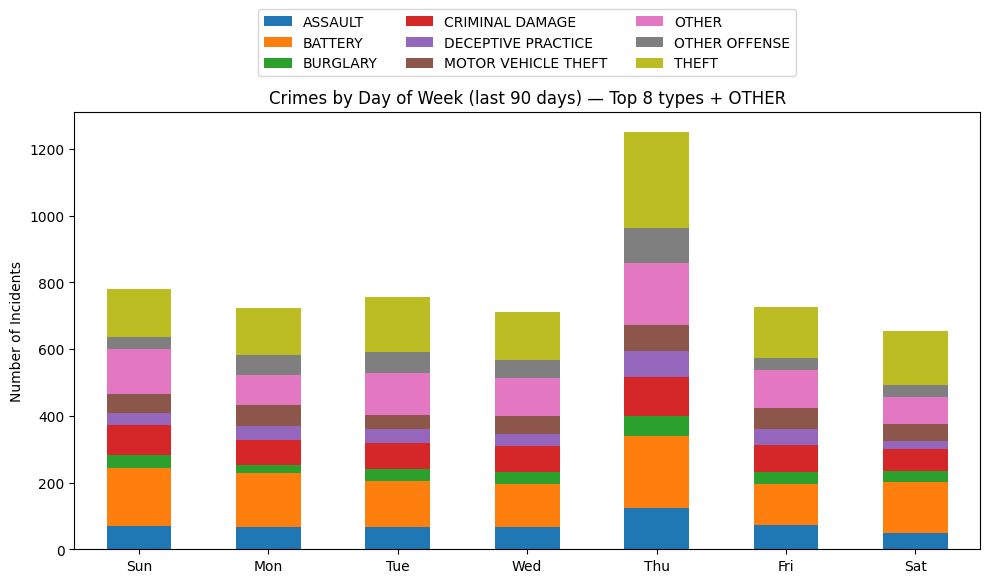

In [14]:
# Crimes by day of the week 
window_days = 90
topN = 8

# Find the overall top N crime types in that window
df_top = q(f"""
SELECT primary_type, COUNT(*) AS n
FROM public_stg.stg_chicago_crimes
WHERE date >= NOW() - INTERVAL '{window_days} days'
GROUP BY 1
ORDER BY n DESC
""")

top_types = df_top["primary_type"].head(topN).tolist()

# Relabel non-top types as "OTHER" and re-pivot
df_dow_top = df_dow.copy()
df_dow_top["ptype_top"] = df_dow_top["primary_type"].where(
    df_dow_top["primary_type"].isin(top_types), other="OTHER"
)

pivot_dow_top = (df_dow_top
                 .pivot_table(index="dow", columns="ptype_top", values="n", aggfunc="sum")
                 .reindex(range(7))
                 .fillna(0)
                 .astype(int))

# Stacked bar with compact legend
ax = pivot_dow_top.plot(kind="bar", stacked=True, figsize=(10,6))
ax.set_title(f"Crimes by Day of Week (last {window_days} days) — Top {topN} types + OTHER")
ax.set_xlabel("")
ax.set_ylabel("Number of Incidents")
ax.set_xticklabels(["Sun","Mon","Tue","Wed","Thu","Fri","Sat"], rotation=0)
ax.legend(title="", ncols=3, bbox_to_anchor=(0.5, 1.25), loc="upper center")
plt.tight_layout()
plt.show()

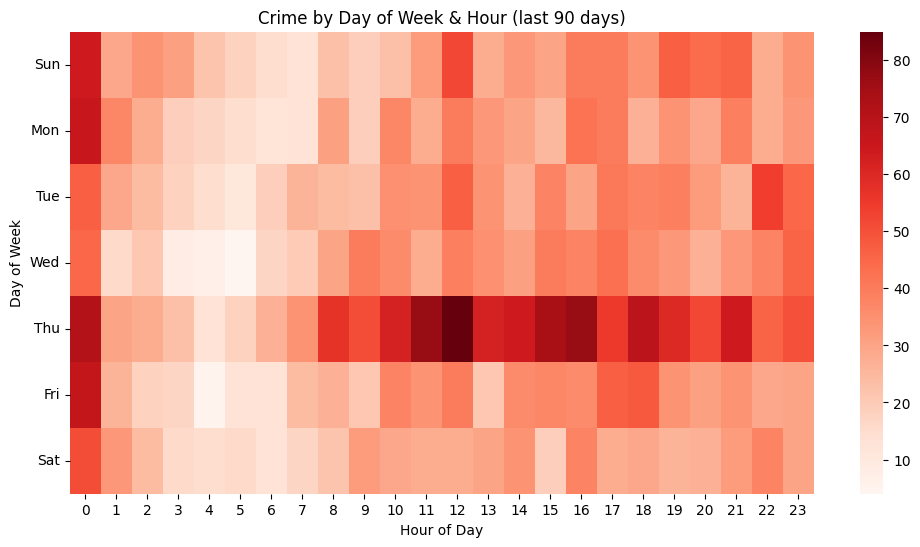

In [ ]:
import seaborn as sns
import numpy as np

df_heatmap = q("""
SELECT
    EXTRACT(DOW FROM date)::int AS dow,
    EXTRACT(HOUR FROM date)::int AS hour,
    COUNT(*) AS n
FROM public_stg.stg_chicago_crimes
WHERE date >= NOW() - INTERVAL '90 days'
GROUP BY 1, 2
ORDER BY dow, hour;
""")

pivot = df_heatmap.pivot(index="dow", columns="hour", values="n").fillna(0)

plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap="Reds")
plt.title("Crime by Day of Week & Hour (last 90 days)")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.yticks(ticks=np.arange(7)+0.5, labels=["Sun","Mon","Tue","Wed","Thu","Fri","Sat"], rotation=0)
plt.show()

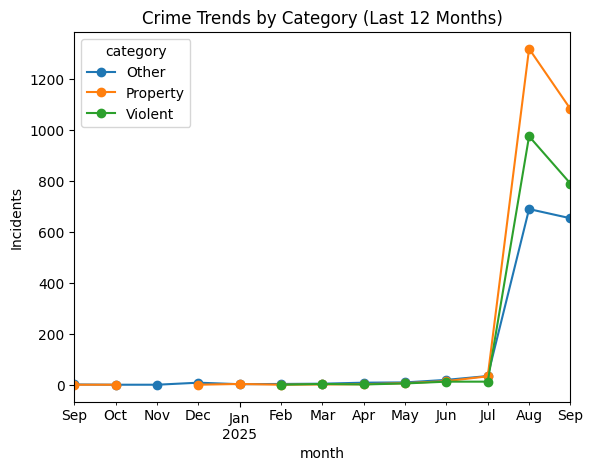

In [ ]:
# Group crimes into categories 
df_categories = q("""
SELECT DATE_TRUNC('month', date) AS month,
    CASE 
        WHEN primary_type IN ('HOMICIDE', 'ASSAULT', 'BATTERY', 'ROBBERY') THEN 'Violent'
        WHEN primary_type IN ('BURGLARY','THEFT','MOTOR VEHICLE THEFT','CRIMINAL DAMAGE') THEN 'Property'
        ELSE 'Other'
    END AS category,
    COUNT(*) AS n
FROM public_stg.stg_chicago_crimes
WHERE date >= NOW() - INTERVAL '12 months'
GROUP BY 1, 2
ORDER BY month, category;
""")

df_categories.pivot(index='month', columns='category', values='n').plot(kind='line', marker='o')
plt.title("Crime Trends by Category (Last 12 Months)")
plt.ylabel("Incidents")
plt.show()

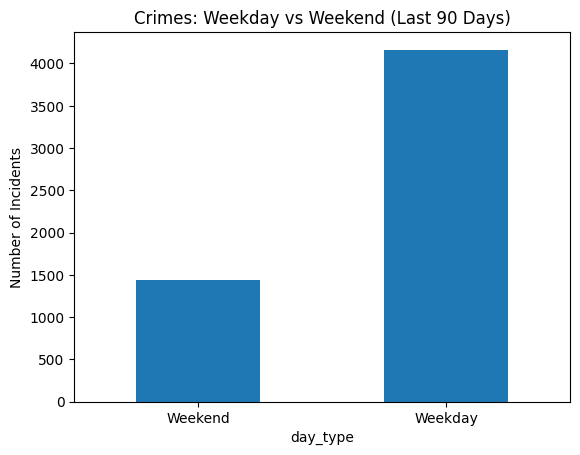

In [ ]:
# Weekdays vs weekends 
df_weekend = q("""
SELECT 
    CASE WHEN EXTRACT(DOW FROM date) IN (0,6) THEN 'Weekend' ELSE 'Weekday' END as day_type,
    COUNT(*) AS n
FROM public_stg.stg_chicago_crimes
WHERE date>= NOW() - INTERVAL '90 days'
GROUP BY 1;
""")
df_weekend.plot(kind='bar', x='day_type', y='n', legend=False)
plt.title('Crimes: Weekday vs Weekend (Last 90 Days)')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=0)
plt.show()

## 4. Location Hotspots (Location × Hour Heatmap)

**What this shows:** Heatmap of top locations by hour of day over the selected window.  
**Why it matters:** Surfaces spatial-temporal hotspots (e.g., Street, Apartment) for targeted interventions.

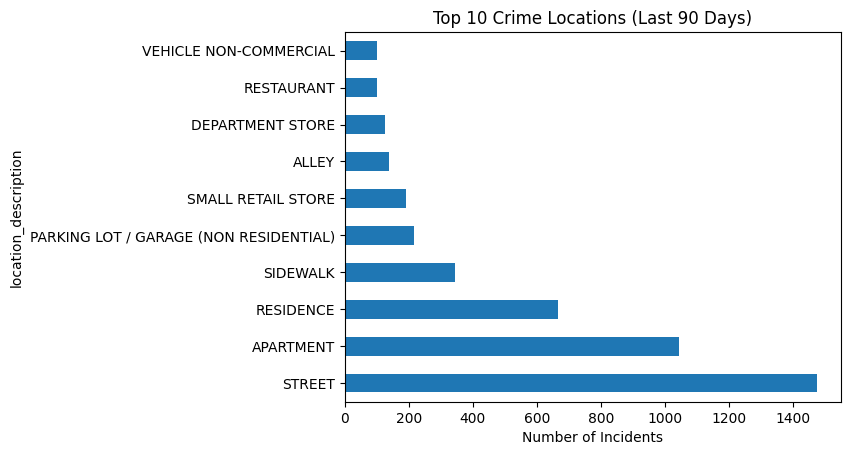

In [ ]:
df_hotspots = q("""
SELECT 
    location_description,
    COUNT(*) AS n
FROM public_stg.stg_chicago_crimes
WHERE date >= NOW() - INTERVAL '90 days'
GROUP BY 1
ORDER BY n DESC
LIMIT 10;
""")
df_hotspots.plot(kind="barh", x="location_description", y="n", legend=False)
plt.title("Top 10 Crime Locations (Last 90 Days)")
plt.xlabel("Number of Incidents")
plt.show()

In [ ]:
# Hotspots by crime type 
df_loc_type = q("""
SELECT 
    location_description,
    CASE
        WHEN primary_type IN ('HOMICIDE','ASSAULT','BATTERY','ROBBERY','CRIMINAL SEXUAL ASSAULT') THEN 'Violent'
        WHEN primary_type IN ('BURGLARY','THEFT','MOTOR VEHICLE THEFT','ARSON','CRIMINAL DAMAGE') THEN 'Property'
        ELSE 'Other'
    END AS category,
    COUNT(*) AS n
FROM public_stg.stg_chicago_crimes
WHERE date >= NOW() - INTERVAL '90 days'
GROUP BY 1, 2
ORDER BY n DESC;
""")
df_loc_type

,location_description,category,n
0,STREET,Property,862
1,APARTMENT,Violent,474
2,STREET,Violent,331
3,APARTMENT,Property,309
4,STREET,Other,282
...,...,...,...
195,VEHICLE - COMMERCIAL: TROLLEY BUS,Violent,1
196,CTA PLATFORM,Property,1
197,BARBERSHOP,Violent,1
198,COIN OPERATED MACHINE,Violent,1


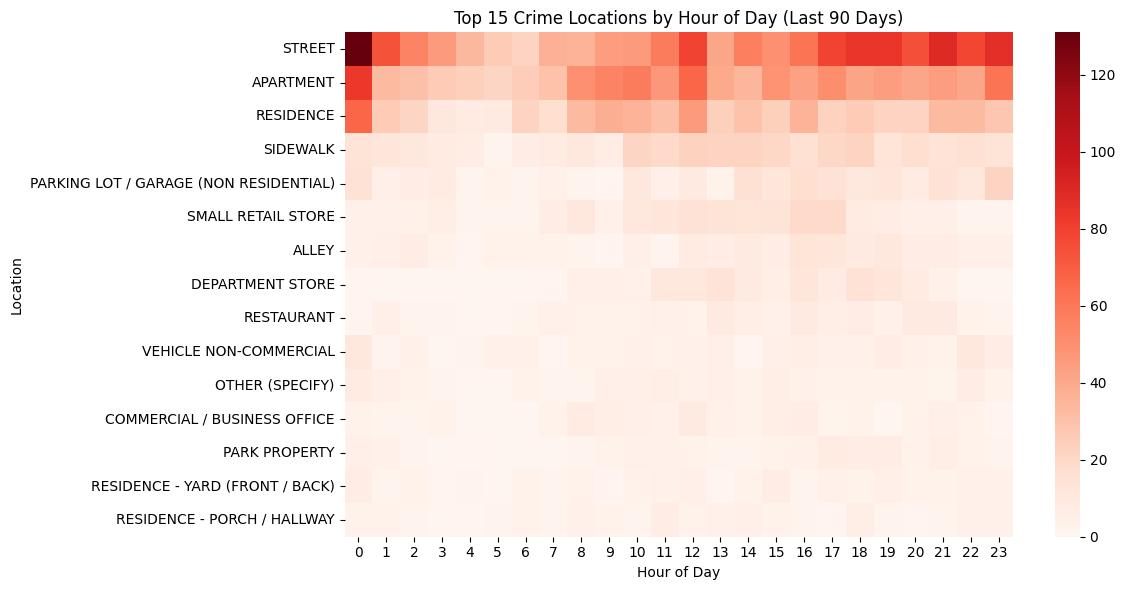

In [ ]:
# Top 15 locations × hour heatmap (last 90 days)
df_loc_hour = q("""
WITH base AS (
    SELECT 
        COALESCE(NULLIF(location_description, ''), 'UNKNOWN') AS loc,
        EXTRACT(HOUR FROM date)::int AS hour,
        COUNT(*) AS n
    FROM public_stg.stg_chicago_crimes
    WHERE date >= NOW() - INTERVAL '90 days'
    GROUP BY 1, 2
),
top_locs AS (
    SELECT loc
    FROM base
    GROUP BY loc
    ORDER BY SUM(n) DESC
    LIMIT 15
)
SELECT b.loc, b.hour, b.n
FROM base b
JOIN top_locs t ON t.loc = b.loc
ORDER BY b.loc, b.hour;
""")

# Pivot to matrix: rows = location, cols = hour
pivot_loc_hour = (
    df_loc_hour
    .pivot(index="loc", columns="hour", values="n")
    .reindex(columns=range(24))     # ensure 0..23 present and in order
    .fillna(0)
)

# Sort locations by total incidents (descending)
pivot_loc_hour = pivot_loc_hour.loc[pivot_loc_hour.sum(axis=1).sort_values(ascending=False).index]

plt.figure(figsize=(12,6))
sns.heatmap(pivot_loc_hour, cmap="Reds")
plt.title("Top 15 Crime Locations by Hour of Day (Last 90 Days)")
plt.xlabel("Hour of Day")
plt.ylabel("Location")
plt.tight_layout()
plt.show()

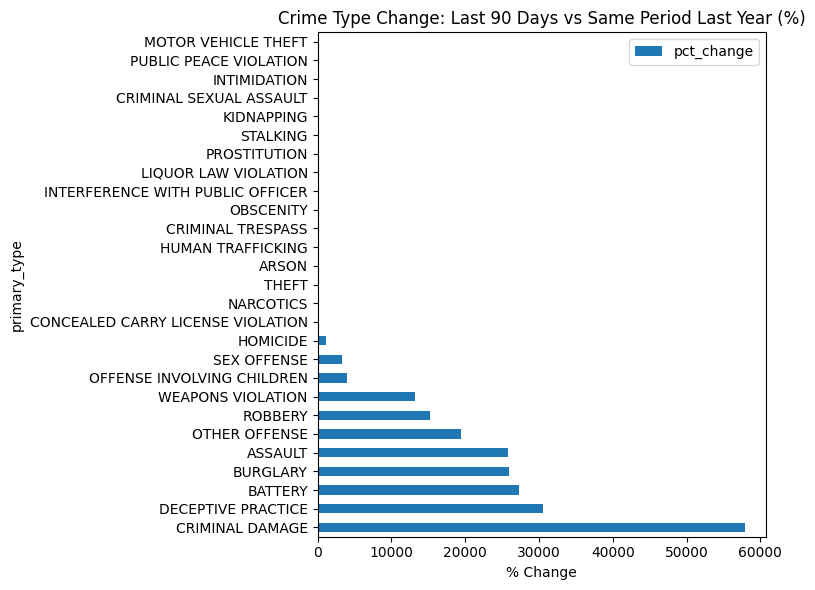

In [ ]:
df_compare = q("""
WITH recent AS (
    SELECT primary_type, COUNT(*) AS n
    FROM public_stg.stg_chicago_crimes
    WHERE date >= NOW() - INTERVAL '90 days'
    GROUP BY 1
),
last_year AS (
    SELECT primary_type, COUNT(*) AS n
    FROM public_stg.stg_chicago_crimes
    WHERE date BETWEEN (NOW() - INTERVAL '1 year' - INTERVAL '90 days')
                  AND (NOW() - INTERVAL '1 year')
    GROUP BY 1
)
SELECT r.primary_type,
       r.n AS recent_n,
       COALESCE(l.n,0) AS last_year_n,
       ROUND(100.0*(r.n-COALESCE(l.n,0))/NULLIF(l.n,0),1) AS pct_change
FROM recent r
LEFT JOIN last_year l USING(primary_type)
ORDER BY pct_change DESC NULLS LAST;
""")

df_compare.plot(x="primary_type", y="pct_change", kind="barh", figsize=(8,6))
plt.title("Crime Type Change: Last 90 Days vs Same Period Last Year (%)")
plt.xlabel("% Change")
plt.tight_layout()
plt.show()

In [ ]:
# Absolute counts
df_change = q("""
WITH recent AS (
    SELECT primary_type, COUNT(*) AS n_recent
    FROM public_stg.stg_chicago_crimes
    WHERE date >= NOW() - INTERVAL '90 days'
    GROUP BY primary_type
),
prev AS (
    SELECT primary_type, COUNT(*) AS n_prev
    FROM public_stg.stg_chicago_crimes
    WHERE date >= NOW() - INTERVAL '1 year 90 days'
      AND date < NOW() - INTERVAL '1 year'
    GROUP BY primary_type
)
SELECT 
    COALESCE(r.primary_type, p.primary_type) AS primary_type,
    COALESCE(n_recent, 0) AS n_recent,
    COALESCE(n_prev, 0) AS n_prev,
    COALESCE(n_recent, 0) - COALESCE(n_prev, 0) AS abs_change,
    CASE WHEN COALESCE(n_prev, 0) = 0 THEN NULL
         ELSE ROUND(100.0 * (COALESCE(n_recent,0) - COALESCE(n_prev,0)) / n_prev, 2)
    END AS pct_change
FROM recent r
FULL OUTER JOIN prev p USING (primary_type)
ORDER BY abs_change DESC;
""")

## 5. Top Movers (Absolute & % Change)

**What this shows:** Crime types with largest month-over-month changes (absolute and percent).  
**Why it matters:** Flags emerging categories (or reporting changes) needing quick attention.

> Caveat: Percent change can be noisy on tiny baselines; we filter/annotate those.

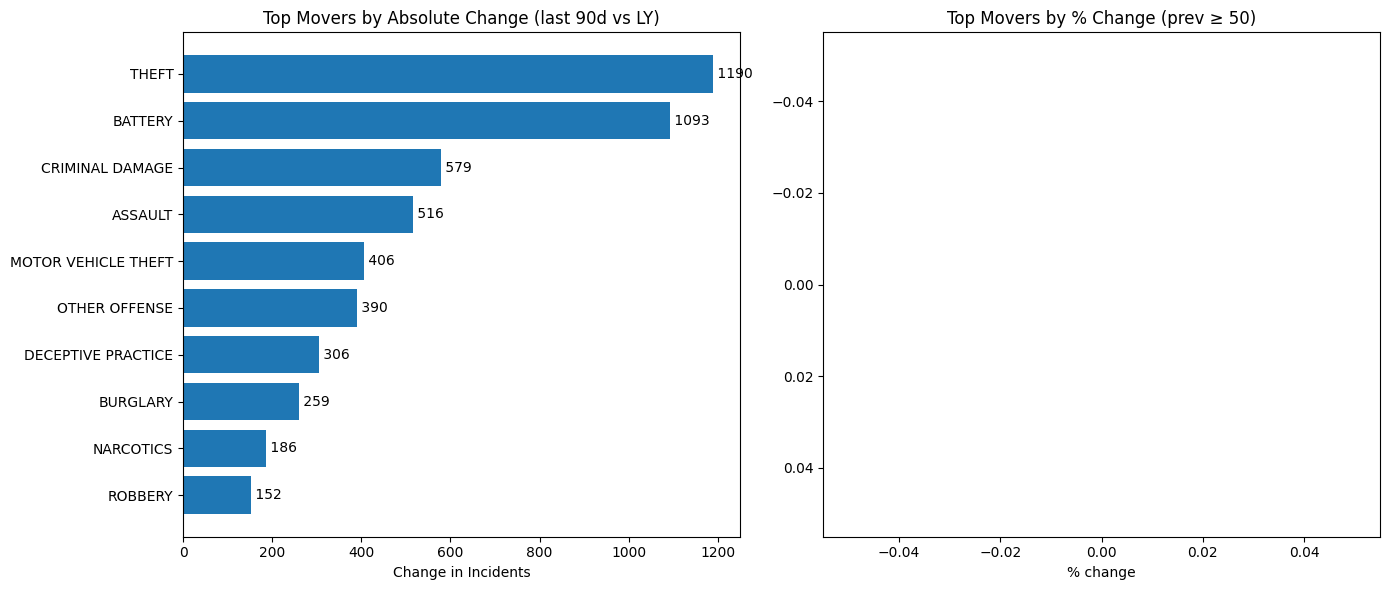

In [ ]:
# Absolute change vs % change 

# Clean and sort 
dfc = df_change.copy()

# Guard against NaNs and inf
dfc['pct_change'] = pd.to_numeric(dfc['pct_change'], errors='coerce').replace([np.inf, -np.inf], np.nan)
dfc['abs_change'] = pd.to_numeric(dfc['abs_change'], errors='coerce').fillna(0).astype(int)
dfc['n_prev'] = pd.to_numeric(dfc['n_prev'], errors='coerce').fillna(0).astype(int)

# Top 10 by absolute change 
top_abs = dfc.sort_values(by='abs_change', ascending=False).head(10)

# Top 10 by percent change 
base_threshold = 50

top_pct = (dfc[dfc["n_prev"] >= base_threshold]
           .dropna(subset=["pct_change"])
           .sort_values("pct_change", ascending=False)
           .head(10))

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14,6))

axes[0].barh(top_abs['primary_type'], top_abs['abs_change'])
axes[0].invert_yaxis()
axes[0].set_title('Top Movers by Absolute Change (last 90d vs LY)')
axes[0].set_xlabel('Change in Incidents')
for i, v in enumerate(top_abs['abs_change']):
    axes[0].text(v, i, f' {v}', va='center')

# Percent change (with baseline filter)
axes[1].barh(top_pct["primary_type"], top_pct["pct_change"])
axes[1].invert_yaxis()
axes[1].set_title(f"Top Movers by % Change (prev ≥ {base_threshold})")
axes[1].set_xlabel("% change")
for i, v in enumerate(top_pct["pct_change"]):
    axes[1].text(v, i, f"  {v:.0f}%", va="center")

plt.tight_layout()
plt.show()

In [ ]:
dfc[['primary_type', 'n_recent', 'n_prev', 'abs_change', 'pct_change']]\
    .sort_values('n_prev', ascending=True).head(20)

,primary_type,n_recent,n_prev,abs_change,pct_change
0,THEFT,1190,0,1190,NaN
24,OBSCENITY,2,0,2,NaN
23,INTIMIDATION,2,0,2,NaN
22,CONCEALED CARRY LICENSE VIOLATION,2,0,2,NaN
21,LIQUOR LAW VIOLATION,6,0,6,NaN
20,ARSON,7,0,7,NaN
18,STALKING,12,0,12,NaN
17,PROSTITUTION,19,0,19,NaN
16,INTERFERENCE WITH PUBLIC OFFICER,26,0,26,NaN
15,PUBLIC PEACE VIOLATION,27,0,27,NaN


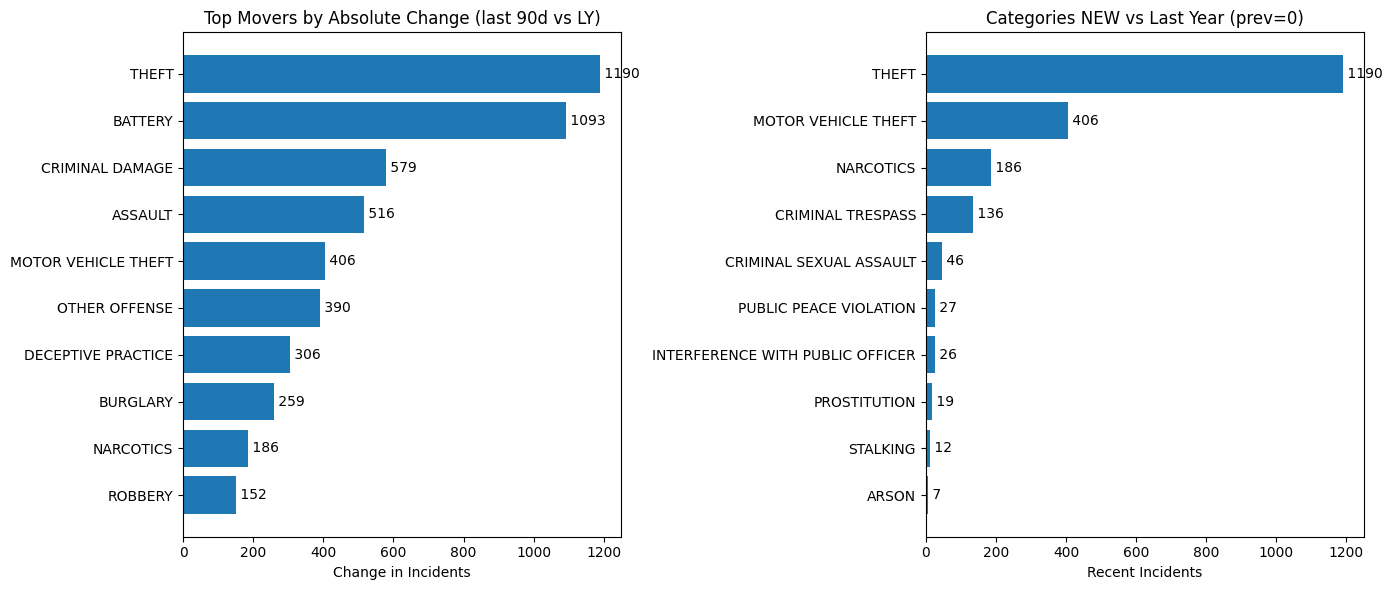

In [ ]:
# Absolute movers (ignore %)
top_abs = dfc.sort_values('abs_change', ascending=False).head(10)

# Categories that are NEW this year (n_prev = 0 but n_recent > 0)
new_now = (
    dfc[(dfc['n_prev'] == 0) & (dfc['n_recent'] > 0)]
    .sort_values('n_recent', ascending=False)
    .head(10)
)

# Categories with tiny baseline (n_prev=1) – flag as "unstable %"
unstable_pct = (
    dfc[dfc["n_prev"] == 1]
    .sort_values("pct_change", ascending=False)
    .head(10)
)

fig, axes = plt.subplots(1, 2, figsize=(14,6))

# --- Absolute movers ---
axes[0].barh(top_abs['primary_type'], top_abs['abs_change'])
axes[0].invert_yaxis()
axes[0].set_title('Top Movers by Absolute Change (last 90d vs LY)')
axes[0].set_xlabel('Change in Incidents')
for i, v in enumerate(top_abs['abs_change']):
    axes[0].text(v, i, f' {v}', va='center')

# --- NEW categories (prev=0) ---
axes[1].barh(new_now["primary_type"], new_now["n_recent"])
axes[1].invert_yaxis()
axes[1].set_title("Categories NEW vs Last Year (prev=0)")
axes[1].set_xlabel("Recent Incidents")
for i, v in enumerate(new_now["n_recent"]):
    axes[1].text(v, i, f" {v}", va="center")

plt.tight_layout()
plt.show()

- **Left panel:** Theft (+1191) and Battery (+1093) are the absolute drivers of the recent spike in incidents.

- **Right panel:** Several categories (e.g. Theft, Motor Vehicle Theft, Narcotics, Criminal Trespass) are showing up as “new vs last year” — but that’s really because baseline (last year’s data) was essentially empty in the dataset.

In [ ]:
q("""
SELECT DATE_TRUNC('year', date) AS year, COUNT(*)
FROM public_stg.stg_chicago_crimes
GROUP BY 1
ORDER BY 1;
""")

,year,count
0,2001-01-01,4
1,2004-01-01,1
2,2010-01-01,2
3,2012-01-01,2
4,2014-01-01,2
5,2015-01-01,3
6,2016-01-01,3
7,2017-01-01,3
8,2018-01-01,4
9,2019-01-01,4


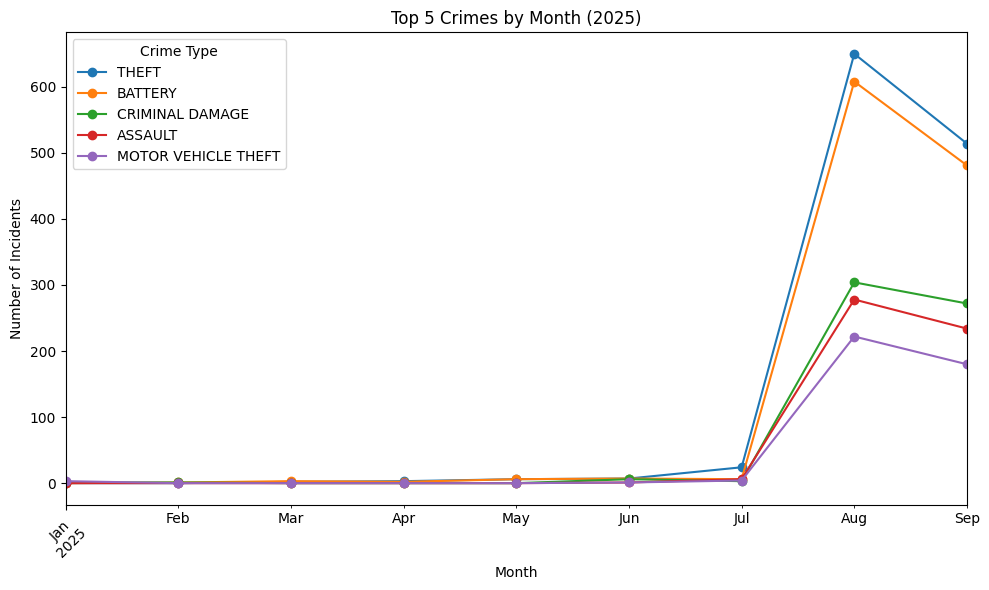

In [ ]:
# Top 5 crimes by month (2025)

# Month x type counts from SQL
df_month = q("""
SELECT
  DATE_TRUNC('month', date)::date AS month,   -- returns a DATE (yyyy-mm-01)
  primary_type,
  COUNT(*) AS n
FROM public_stg.stg_chicago_crimes
GROUP BY 1, 2
ORDER BY 1, 2;
""")

# Pivot to wide, then force a true DatetimeIndex and sort
pivot = (df_month
         .pivot_table(index="month", columns="primary_type", values="n", fill_value=0))

# Ensure index is pandas Timestamps (not datetime.date) and sorted
pivot.index = pd.to_datetime(pivot.index)   # <--- key line
pivot = pivot.sort_index()

# Filter to 2025 using a boolean mask (no exact key lookup)
start_2025 = pd.Timestamp("2025-01-01")
pivot_2025 = pivot.loc[pivot.index >= start_2025]

# Pick top 5 within the 2025 window
top5_types = pivot_2025.sum(axis=0).sort_values(ascending=False).head(5).index.tolist()

# Plot those columns for 2025
ax = pivot_2025[top5_types].plot(marker="o", figsize=(10,6))
ax.set_title("Top 5 Crimes by Month (2025)")
ax.set_xlabel("Month")
ax.set_ylabel("Number of Incidents")
plt.xticks(rotation=45)
plt.legend(title="Crime Type")
plt.tight_layout()
plt.show()

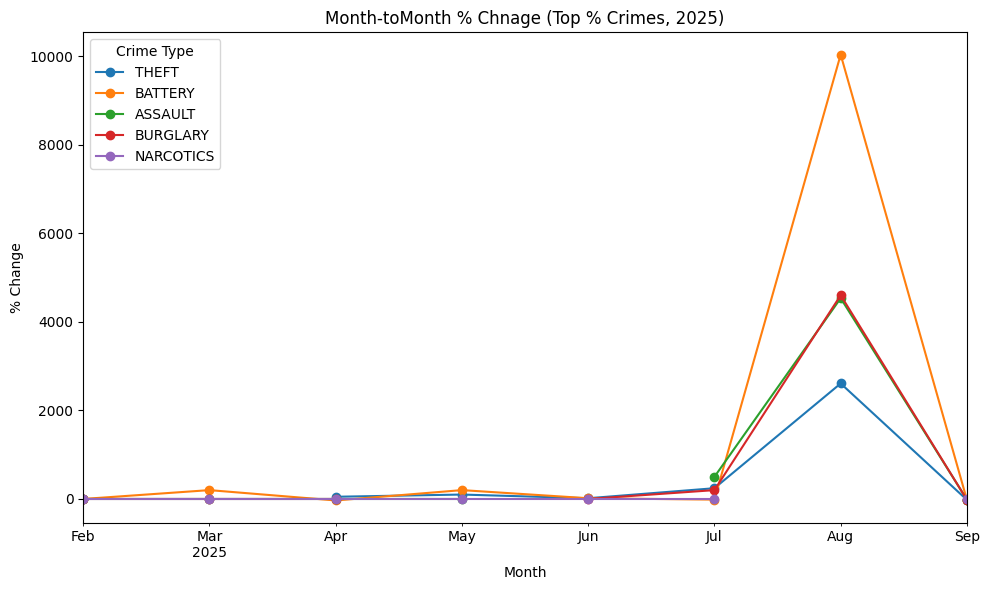

In [ ]:
df_pct = df_top_2025.pct_change().fillna(0) * 100

df_pct.plot(marker='o', figsize=(10,6))
plt.title('Month-toMonth % Chnage (Top % Crimes, 2025)')
plt.xlabel('Month')
plt.ylabel('% Change')
plt.xticks(rotation=45)
plt.legend(title="Crime Type")
plt.tight_layout()
plt.show()

/var/folders/6z/l9wv3crd4n5bzgcrdd7vxq8m0000gn/T/ipykernel_31668/2969518893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_2025["Other"] = df_month.loc[df_top_2025.index].sum(axis=1) - df_top_2025.sum(axis=1)


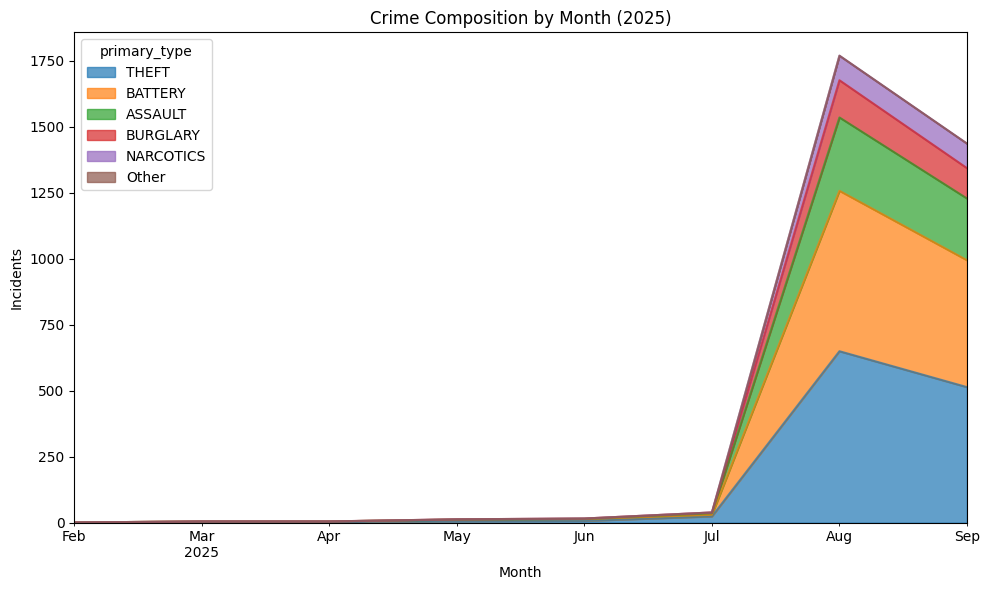

In [ ]:
df_top_2025["Other"] = df_month.loc[df_top_2025.index].sum(axis=1) - df_top_2025.sum(axis=1)

df_top_2025[["THEFT", "BATTERY", "ASSAULT", "BURGLARY", "NARCOTICS", "Other"]]\
    .plot.area(figsize=(10,6), stacked=True, alpha=0.7)

plt.title("Crime Composition by Month (2025)")
plt.xlabel("Month")
plt.ylabel("Incidents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
q("""
SELECT DATE_TRUNC('month', date) AS month,
       COUNT(*) AS n
FROM public_stg.stg_chicago_crimes
GROUP BY 1
ORDER BY 1;
  """)

,month,n
0,2001-08-01,3
1,2001-11-01,1
2,2004-03-01,1
3,2010-04-01,1
4,2010-06-01,1
...,...,...
62,2025-05-01,23
63,2025-06-01,48
64,2025-07-01,82
65,2025-08-01,2980
